In [1]:
from torchvision import datasets, transforms

# Loading the training and testing datasets

train = datasets.MNIST(root='mnist', train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST(root='mnist', train=False, download=True, transform=transforms.ToTensor())

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

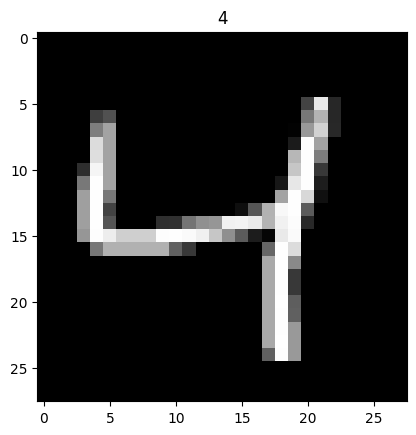

In [3]:
import matplotlib.pyplot as plt

image, number = train[2]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'{number}')
plt.show()

In [4]:
from skimage.morphology import skeletonize, dilation, square
from torch.utils.data import TensorDataset

# Skeletonize all the data (Sacrificing some acc for speed and for fun)

def skeletonization(dataset):
    skeletons = []
    labels = []
    
    for image, number in dataset:
        img = image.squeeze().numpy()
        img = dilation(img, square(1))
        img = skeletonize(img, method='lee')
        
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) # Back to Tensor
        
        skeletons.append(img)
        labels.append(number)
    
    return skeletons, labels

train_images, train_labels = skeletonization(train)
test_images, test_labels = skeletonization(test)

train_tensor_img = torch.stack(train_images)
train_tensor_label = torch.tensor(train_labels)

test_tensor_img = torch.stack(test_images)
test_tensor_label = torch.tensor(test_labels)

train = TensorDataset(train_tensor_img, train_tensor_label)
test = TensorDataset(test_tensor_img, test_tensor_label)

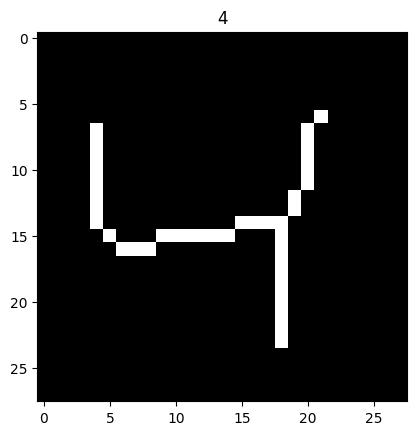

In [5]:
image, number = train[2]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'{number}')
plt.show()

In [6]:
from torch.utils.data import DataLoader

# Making use of data loaders

train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [7]:
len(train_loader)

469

In [8]:
import torch.nn as nn
import torch.optim as optim

class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNeuralNet, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim) # First fully connected layer
        self.relu = nn.ReLU() # The activation function
        self.l2 = nn.Linear(hidden_dim, output_dim) # Second fully connected layer
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x
    
input_dim = 784 # No. pixels
hidden_dim = 100 # No. neurons in the hidden layer
output_dim = 10 # No. output classes 

model = SimpleNeuralNet(input_dim, hidden_dim, output_dim)

n_o_f_epochs = 2
n_o_f_batches = len(train_loader)
lr = 0.007

loss = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []

# Training loop

for epoch in range(n_o_f_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        
        # Forward
        
        outputs = model(images) # The predictions
        curr_loss = loss(outputs, labels) # Predictions compared to actual labels
        losses.append(curr_loss.item())
        
        # Backward
        
        optimizer.zero_grad() # Clears gradients
        curr_loss.backward() 
        optimizer.step() # Parameter update
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1}/{n_o_f_epochs}, step {i+1}/{n_o_f_batches}, loss = {curr_loss.item()}')

# Testing

with torch.no_grad(): # Disables gradient computation
    n_o_f_correct = 0
    n_o_f_t_samples = 0
    
    for images, labels in test_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        
        n_o_f_t_samples += labels.shape[0]
        n_o_f_correct += (pred == labels).sum().item()
        
    acc = 100.0 * n_o_f_correct / n_o_f_t_samples
    print(f'accuracy = {acc}')

epoch 1/2, step 100/469, loss = 0.5286524295806885
epoch 1/2, step 200/469, loss = 0.8582267761230469
epoch 1/2, step 300/469, loss = 0.553737461566925
epoch 1/2, step 400/469, loss = 0.4132741391658783
epoch 2/2, step 100/469, loss = 0.45494982600212097
epoch 2/2, step 200/469, loss = 0.43423616886138916
epoch 2/2, step 300/469, loss = 0.327576220035553
epoch 2/2, step 400/469, loss = 0.4968832731246948
accuracy = 87.46


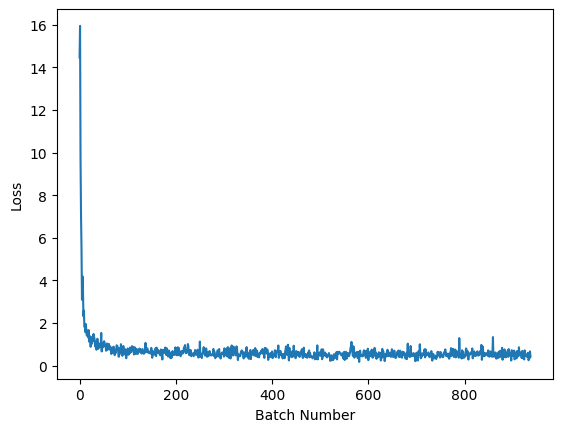

In [9]:
plt.plot(losses)
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()